# GCN Deconvolution

Michael, November 2022

Two interesting problems in spatial omics analysis are cell deconvolution and RNA imputation. What if we can solve both of these problems with one objective?

[Song and Su, 2021](https://academic.oup.com/bib/article/22/5/bbaa414/6105942) attempts to deconvolve cell composition with GNNs. This does not reconstruct the underlying gene expression of each spot.

[SpatialDWLS](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02362-7) uses a reference scRNA-seq dataset and treats cell deconvolution as a least-squares optimization problem.

[Wu et al., 2022](https://www.nature.com/articles/s41551-022-00951-w) uses graph deep learning to characterize groups of cells that they call microenvironments. They can generate insights by clustering graphs based on the center cell embedding and correlating that with outcome. Their final prediction is made through global mean aggregation. They also generate Voronoi diagrams to infer the 2D spatial structure of the cells, which I may use as well.

I have tried predicting gene expression with CNNs. It kind of works, but it is highly constrained imo and surprisingly doesn't have many distinct output states.

My proposed objective function is to take the sum of the predicted counts of each cell in a Visium spot, and try to make that sum resemble the measured total counts within the spot. Hopefully, this would enable the model to deconstruct the gene expression of each cell. I want to make sure that the individual cells resemble single-cell data somehow, and I'm not sure the best way to do that yet. I might add an objective that minimizes the distance between the cell's gene expression and the nearest-neighbor single-cell datapoint.

## Step 1: Data Loading

I will use the cell detecting Mask-RCNN that Cyril trained to create the initial cell graph.

To create the cell graph, I will take the point locations of each cell and generate a Voronoi diagram. The library used by Wu et al. may be useful here: [`geovoronoi`](https://pypi.org/project/geovoronoi/). Then, any adjacent cells will be counted as neighbors.

In [30]:
import pickle
import numpy as np

def load_cell_data():
    store = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store'
    
    with open(f"{store}/xcoords.pickle", "rb") as f:
        xcoords = pickle.load(f)

    with open(f"{store}/ycoords.pickle", "rb") as f:
        ycoords = pickle.load(f)

    with open(f"{store}/patchxy.pickle", 'rb') as f:
        patch_xy = pickle.load(f)
        
    with open(f"{store}/cnn_embed.pickle", "rb") as f:
        embeddings = pickle.load(f)

    slide_cell_locations_all = {}
    slide_embeddings_all = {}
    for slide in ['A1', 'B1', 'C1', 'D1']:
        cell_x = []
        cell_y = []
        embeddings_ = []
        
        xy_set = set()

        cell_counter = 0
        for patch_i, (patch_x, patch_y) in enumerate(patch_xy[slide]):
            for cell_i in range(len(xcoords[slide][patch_i])):
                x = xcoords[slide][patch_i][cell_i] + patch_x
                y = ycoords[slide][patch_i][cell_i] + patch_y
                
                embedding = embeddings[slide][cell_counter]
                
                cell_counter += 1
                
                # Remove duplicates, which does happen sometimes
                if (x, y) in xy_set:
                    continue
                    
                xy_set.add((x, y))

                cell_x.append(x)
                cell_y.append(y)
                embeddings_.append(embedding)
                
        slide_cell_locations_all[slide] = np.vstack([cell_x, cell_y]).T
        slide_embeddings_all[slide] = np.array(embeddings_)
        
    return slide_cell_locations_all, slide_embeddings_all

In [31]:
# We will filter this when we create the adjacency matrix
locations_tmp, embeddings_tmp = load_cell_data()

In [32]:
assert locations_tmp['A1'].shape[0] == embeddings_tmp['A1'].shape[0]

## Step 2: Creating the Cell Adjacency Matrix

According to Wu et al.:

> For each multiplexed fluorescence image, we identified individual cells using the segmentation and classification pipeline stated above. The set of cells was represented by a set of discrete points located at cellular centroids. The 2D coordinates of these cellular centroids were determined by the segmentation masks of the corresponding cell nuclei.
>
> To capture the spatial neighbourhood relations, we ran a Delaunay triangulation operation on all the cellular centroids. Corresponding Voronoi diagrams could be uniquely determined by connecting the centres of the circumcircles. We employed the function `voronoi_regions_from_coords` from the package geovoronoi (https://pypi.org/project/geovoronoi/) in this step.

[`voronoi_regions_from_coords`](https://github.com/WZBSocialScienceCenter/geovoronoi) requires a geographic area shape to bound the generated regions. For now, I'll just make this the bounding box of the detected cells. I can crop out any cells that border this bounding box and probably not lose too much detail.

`voronoi_regions_from_coords` returns `region_polys`, a dict that maps Voronoi region IDs to shapely Polygon objects that represent the shape of the respective Voronoi region, and `region_pts`, a dict that maps Voronoi region IDs to a list of indices corresponding to coordinates that fell in that polygon. `region_pts` is useful if we have duplicate points that fall within the same Voronoi region.


In [33]:
import geovoronoi
import shapely    # Required by `geovoronoi` to provide geographic area shape

def create_voronoi_regions(cell_locations):
    min_x = np.min(cell_locations[:, 0])
    max_x = np.max(cell_locations[:, 0])
    min_y = np.min(cell_locations[:, 1])
    max_y = np.max(cell_locations[:, 1])
    
    bounding_rect = shapely.geometry.Polygon([
        [min_x, min_y],
        [min_x, max_y],
        [max_x, max_y],
        [max_x, min_y],
    ])
    
    region_polys, region_pts = geovoronoi.voronoi_regions_from_coords(cell_locations, bounding_rect)
    
    filtered_polys = []
    filtered_region_pts = []
    
    for i, polygon in region_polys.items():
        polygon_min_x, polygon_min_y, polygon_max_x, polygon_max_y = polygon.bounds
        if (polygon_min_x == min_x or
            polygon_min_y == min_y or
            polygon_max_x == max_x or
            polygon_max_y == max_y):
            continue
        
        filtered_polys.append(polygon)
        filtered_region_pts.append(region_pts[i])
    
    return filtered_polys, filtered_region_pts

In [34]:
regions = {}
# Create final locations and embeddings dicts, removing droped cells
locations = {}
embeddings = {}

for slide_id in locations_tmp.keys():
    regions[slide_id], preserved_indexes = create_voronoi_regions(locations_tmp[slide_id])
    locations[slide_id] = locations_tmp[slide_id][[x[0] for x in preserved_indexes]]
    embeddings[slide_id] = embeddings_tmp[slide_id][[x[0] for x in preserved_indexes]]

In [35]:
np.array(regions['A1'][0].exterior.coords)

array([[12137.55628518,  7383.64098097],
       [12207.92100098,  7202.70314033],
       [12108.29906299,  7204.45089363],
       [12118.40440706,  7374.55751878],
       [12137.55628518,  7383.64098097]])

In [36]:
assert locations['A1'].shape[0] == embeddings['A1'].shape[0]

In [37]:
# Verify that it worked

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.collections
import matplotlib.cm

plt.rcParams['figure.figsize'] = (10, 10)

def plot_polygons(polygons):
    fig, ax = plt.subplots()
    patches = []
    num_polygons = 5
    num_sides = 5
    
    min_x, min_y, max_x, max_y = polygons[0].bounds

    for polygon in polygons:
        polygon_min_x, polygon_min_y, polygon_max_x, polygon_max_y = polygon.bounds
        
        if polygon_min_x < min_x:
            min_x = polygon_min_x
            
        if polygon_min_y < min_y:
            min_y = polygon_min_y
            
        if polygon_max_x > max_x:
            max_x = polygon_max_x
            
        if polygon_max_y > max_y:
            max_y = polygon_max_y
        
        patches.append(
            matplotlib.patches.Polygon(
                np.array(polygon.exterior.coords),
                True
            )
        )
        
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

    p = matplotlib.collections.PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
    p.set_array(100 * np.random.rand(len(patches)))

    ax.add_collection(p)

    plt.title("Voronoi Diagram of Cells")
    plt.show()

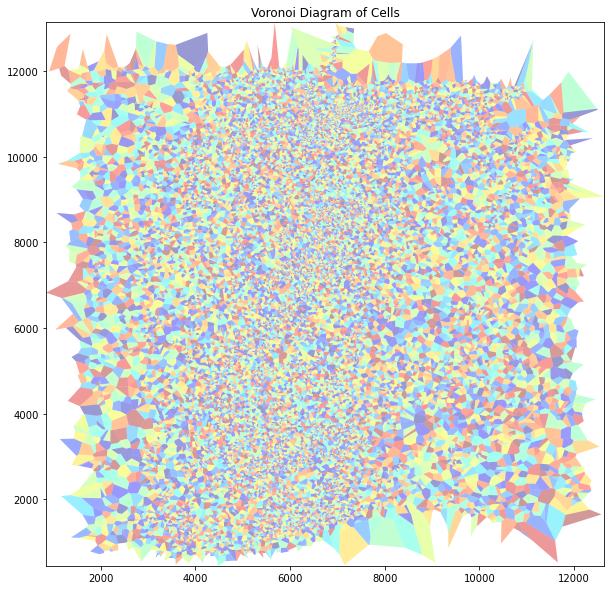

In [38]:
plot_polygons(regions['A1'])

In [39]:
import collections

def create_cell_adjacency_matrix(polygons):
    n = len(polygons)
    adj = np.zeros((n, n), dtype=bool)
    
    edges = collections.defaultdict(list)
    
    # 1) Create dictionary of edge -> polygons (also add self loops)
    # 2) Any polygons that share the same edge will be connected in the end
    
    for polygon_i, polygon in enumerate(polygons):
        adj[polygon_i, polygon_i] = True
        
        coords = list(polygon.exterior.coords)
        
        assert coords[-1] == coords[0]
        
        for coord_i in range(len(coords) - 1):
            p1 = coords[coord_i]
            p2 = coords[coord_i + 1]
            
            edges[(p1, p2)].append(polygon_i)
            edges[(p2, p1)].append(polygon_i)
            
    for having_same_edge in edges.values():
        assert len(having_same_edge) <= 2, f"Expected at most two polygons to share an edge: {having_same_edge}"
        
        if len(having_same_edge) == 2:
            i, j = having_same_edge
            adj[i, j] = True
            adj[j, i] = True
    
    return adj


In [40]:
adjacency_matrices = {}

for slide_id in regions.keys():
    adjacency_matrices[slide_id] = create_cell_adjacency_matrix(regions[slide_id])

In [41]:
avg_neighbors = np.sum(adjacency_matrices[slide_id]) / adjacency_matrices[slide_id].shape[0]
print(f"Average neighbors per cell: {avg_neighbors:.2f}")

assert adjacency_matrices['A1'].shape[0] == len(regions['A1'])
assert adjacency_matrices['A1'].shape[0] == locations['A1'].shape[0]

Average neighbors per cell: 6.97


## Step 3: Creating Cell Subgraphs

Like Wu et al., we'll use a 3-hop neighborhood. However, we'll create this neighborhood for all cells within a Visium node. Cells count as being part of a Visium node if they are with $r$ pixels of the Visium node center.

First, we'll load the Visium node locations. Then, we'll create a parallel array that assigns cells to these nodes.

In [42]:
visium_dir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/DH/visium/preprocessed_data'

with open(f"{visium_dir}/visium_data_filtered_processed.pkl", "rb") as f:
    visium = pickle.load(f)

In [43]:
from collections import defaultdict

def get_indexes_of_cells_under_each_spot(slide, cell_locations, r):
    indexes = []
    counts, visium_locations = slide
    r2 = r * r
    
    # Sort cells into tiles
    tiles = defaultdict(set)
    for cell_i, (cell_x, cell_y) in enumerate(cell_locations):
        for dx in [-r, 0, r]:
            for dy in [-r, 0, r]:
                tiles[(cell_x + dx) // (2 * r), (cell_y + dy) // (2 * r)].add(cell_i)

    for visium_i in range(len(visium_locations)):
        indexes.append([])

        visium_x, visium_y = visium_locations.iloc[visium_i]
        
        search_space = set()
        for dx in [-r, 0, r]:
            for dy in [-r, 0, r]:
                search_space = search_space.union(
                    tiles[(visium_x + dx) // (2 * r), (visium_y + dy) // (2 * r)]
                )

        for cell_i in search_space:
            cell_x, cell_y = cell_locations[cell_i]

            distance = ((cell_x - visium_x) ** 2 + (cell_y - visium_y) ** 2)
            if distance <= r2:
                indexes[-1].append(cell_i)
                
    return indexes

In [44]:
cells_by_spot = {}

for slide_id in visium.keys():
    cells_by_spot[slide_id] = get_indexes_of_cells_under_each_spot(visium[slide_id], locations[slide_id], r=55)

In [45]:
cells_by_spot['A1']

[[],
 [],
 [1153, 1154, 1155],
 [1152],
 [],
 [],
 [],
 [],
 [],
 [386, 387],
 [],
 [],
 [],
 [],
 [43, 30],
 [],
 [32],
 [5574, 407],
 [],
 [5571],
 [2719],
 [9329],
 [],
 [5777, 17789, 17790, 17791],
 [2834],
 [5773],
 [],
 [9605, 9598],
 [5785, 5786],
 [9572, 9574],
 [9611, 13968, 13969, 5789],
 [],
 [2728],
 [],
 [9362, 9363, 1178, 5592, 5597, 5599],
 [21013, 21014, 5594, 23388, 13682, 5626, 2815],
 [],
 [],
 [5623, 5624],
 [21028],
 [13672, 13673, 13678],
 [21023, 13687, 5627, 5629],
 [],
 [9457],
 [9456],
 [21006],
 [17908, 17909, 17916, 17917],
 [24737, 24739, 21105, 21108, 17918],
 [23446, 23447, 23449, 24733, 21113, 21110],
 [13758, 17859, 9415],
 [17922, 7002, 11141, 9382, 9383, 9387, 2759],
 [7004, 19309, 19310, 19314, 15526, 15532, 9410],
 [11155, 15527, 19304, 19305],
 [22024, 22025, 22027, 23972, 23973, 23975],
 [11157, 5618, 3706],
 [11945, 15540, 15542],
 [7784],
 [22378, 16256, 16257, 19863, 11933, 11947, 11948, 11950],
 [],
 [],
 [11939, 4215],
 [11928, 11930, 11931, 

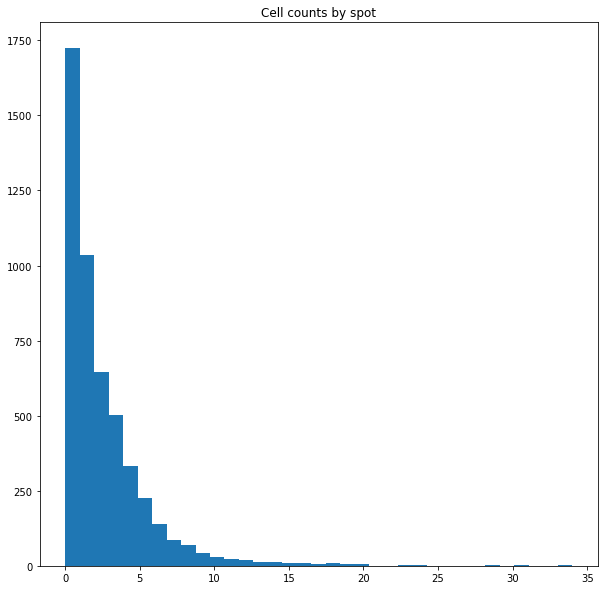

In [46]:
cell_counts_by_spot_A1 = [len(x) for x in cells_by_spot['A1']]

plt.title("Cell counts by spot")
plt.hist(cell_counts_by_spot_A1, bins=35)
plt.show()

In [47]:
# Creating the 3-hop neighborhood
# This only includes the indexes of the cells, the adjacency matrix can be
# constructed by selecting the relevant rows/columns of the main adj matrix

def create_neighborhood(adjacency_matrix, starting_indexes, hop_count):
    accessible = np.zeros(adjacency_matrix.shape[0], dtype=bool)
    accessible[starting_indexes] = True
    
    for hop in range(hop_count):
        accessible = accessible | (accessible @ adjacency_matrix)
        
    return np.where(accessible)[0]

def create_neighborhood_edge_list(edge_list, starting_indexes, hop_count):
    accessible = set(starting_indexes)
    
    for hop in range(hop_count):
        next_accessible = {*accessible}
        for accessible_index in accessible:
            next_accessible.update(edge_list[accessible_index])
            
        accessible = next_accessible
        
    return np.array([*sorted(accessible)])


In [48]:
# Small test

# 3 -> 2 -> 1 -> 0
adj = np.array([
    [0, 0, 0, 0],
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
])

edges = [np.where(adj[i])[0] for i in range(adj.shape[0])]

for create_neighborhood_fn, graph in zip(
    [create_neighborhood, create_neighborhood_edge_list],
    [adj, edges]
):
    assert (create_neighborhood_fn(graph, [2], hop_count=4) == np.array([0, 1, 2])).all()
    assert (create_neighborhood_fn(graph, [2], hop_count=2) == np.array([0, 1, 2])).all()
    assert (create_neighborhood_fn(graph, [3], hop_count=2) == np.array([1, 2, 3])).all()
    assert (create_neighborhood_fn(graph, [3], hop_count=0) == np.array([3])).all()
    assert (create_neighborhood_fn(graph, [1], hop_count=1) == np.array([0, 1])).all()

In [49]:
# Create neighborhoods

import tqdm

neighborhoods_by_spot = {}
edge_lists = {}

for slide_id in cells_by_spot.keys():
    neighborhoods = []
    adj = adjacency_matrices[slide_id]
    edge_lists[slide_id] = [np.where(adj[i])[0] for i in range(adj.shape[0])]
    for spot_i in tqdm.tqdm(range(len(cells_by_spot[slide_id])), desc='Creating neighborhoods for ' + str(slide_id)):
        starting_cells = cells_by_spot[slide_id][spot_i]
        
        neighborhoods.append(
            create_neighborhood_edge_list(edge_lists[slide_id], starting_cells, hop_count=3)
        )
    
    neighborhoods_by_spot[slide_id] = neighborhoods

Creating neighborhoods for D1: 100%|██████████| 4169/4169 [00:00<00:00, 19044.59it/s]


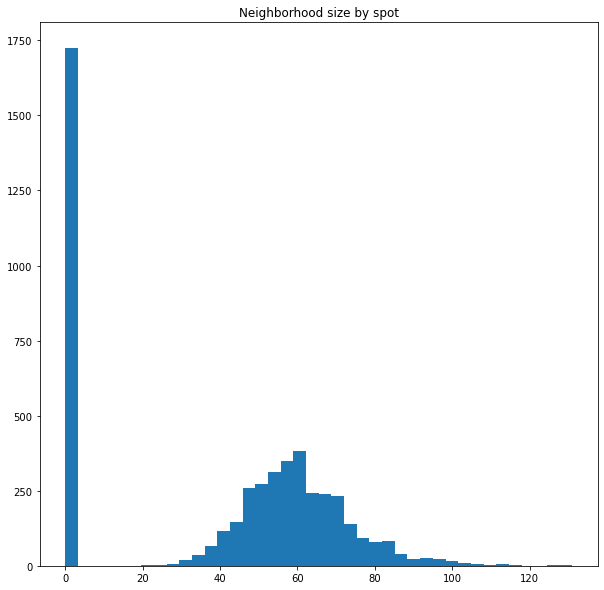

In [50]:
# Check neighborhoods

neighborhood_size_by_spot_A1 = [len(x) for x in neighborhoods_by_spot['A1']]

plt.title("Neighborhood size by spot")
plt.hist(neighborhood_size_by_spot_A1, bins=40)
plt.show()

In [51]:
# How many Visium nodes have no cells?

count_without_cells = (np.array(neighborhood_size_by_spot_A1) == 0).sum()
count_total = len(neighborhood_size_by_spot_A1)

print(f"{count_without_cells=} {count_total=}")
print()
print(f"{100*count_without_cells/count_total:.2f}% of spots have no cells")

count_without_cells=1724 count_total=4950

34.83% of spots have no cells


### Initial Thoughts after Step 3

It's interesting how there are so many Visium spots that simply don't have any cells detected for them. Surely there's something going wrong here with cell detection.

If we go forward from here, we could achieve a high accuracy while being unaware of confounding variables. For example, maybe there's some correlation between which spots get dropped and their gene expression.

## Step 4: Creating Models

We can use PyTorch-Lightning and PyTorch-Geometric.

[`pytorch-geometric`](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html) provides some helpful layers that I can plug and play into my network.

[`pytorch-lightning`](http://pytorchlightning.ai/) is a framework for rapidly prototyping and evaluating models. They are based on the concept of a `LightningModule`, which allows you to specify a loss function and inference function that interop with a `Trainer` that manages checkpointing, data loading, batching, and training/validation loops. Really useful.

I'm creating a `LightningModule` takes a list of embeddings, which of those contribute to the gene expression (have a centroid within the boundaries of the Visium spot), and the total expression, and outputs a loss value. Some hyperparameters are the type of message-passing layer, the number of message-passing layers, the dimensions of each node, and the number of genes.

I will also create a `torch.utils.data.Dataset` which contains an entry for every cell subgraph (aka: every Visium node.) I will filter out any nodes that don't have any cells connected to them; this is something I will need to revisit in the future.

The embeddings will be based on `GNN/store/cnn_embed.pickle`

In [52]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F

class CellSubgraphModel(pl.LightningModule):
    def __init__(self, n_genes: int, GraphLayer: type, d_model: int, n_layers: int):
        super().__init__()
        
        self.n_genes = n_genes
        self.d_model = d_model
        self.n_layers = n_layers
        
        graph_layers = [
            GraphLayer(d_model, d_model) for _ in range(n_layers)
        ]
        self.graph_layers = nn.ModuleList(graph_layers)
        
        self.gene_head = nn.Linear(d_model, n_genes)
        
        self.save_hyperparameters()
        
    def forward(self, embeddings, edge_index):
        for layer_i in range(self.n_layers):
            embeddings = self.graph_layers[layer_i](embeddings, edge_index)
        
        # Final activation is softplus, to ensure that the results are positive
        return F.softplus(self.gene_head(embeddings))
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)
    
    def spot_prediction(self, instance):
        embeddings, edge_index, covered_indexes, counts = instance
        
        cell_predictions = self.forward(embeddings, edge_index)
        spot_prediction = cell_predictions[covered_indexes].sum(dim=0)
        
        return spot_prediction
    
    def training_step(self, batch, batch_idx):
        embeddings, edge_index, covered_indexes, counts = instance = [x[0] for x in batch]
        
        loss = F.mse_loss(torch.log(1 + self.spot_prediction(instance)), torch.log(1 + counts))
        
        self.log('train_loss', loss.item(), prog_bar=True, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        embeddings, edge_index, covered_indexes, counts = instance = [x[0] for x in batch]
        
        loss = F.mse_loss(torch.log(1 + self.spot_prediction(instance)), torch.log(1 + counts))
        
        self.log('validation_loss', loss.item(), prog_bar=True, on_epoch=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        embeddings, edge_index, covered_indexes, counts = instance = [x[0] for x in batch]
        
        loss = F.mse_loss(torch.log(1 + self.spot_prediction(instance)), torch.log(1 + counts))
        
        self.log('test_loss', loss.item(), prog_bar=True, on_epoch=True)
        
        return loss
    
    def predict_step(self, batch, batch_idx):
        return self.spot_prediction([x[0] for x in batch])


In [53]:
import torch.utils.data

def ensure_tensorlist(L):
    return [ensure_tensor(x) for x in L]

def ensure_tensor(x):
    return torch.tensor(x) if type(x) is not torch.Tensor else x

class CellSubgraphDataset(torch.utils.data.Dataset):
    """
    One slide at a time.
    
    Parameters:
    - cell_embeddings: torch.Tensor of cell embeddings
    - cells_by_spot: List of cell indexes corresponding to Visium node
    - neighborhoods_by_spot: List of cell indexes corresponding to Visium node
    - adjacency_matrix: torch.Tensor containing adjacency matrix (cell -> cell)
    - counts: torch.Tensor containing gene counts of each Visium node
    """
    
    def __init__(self, cell_embeddings, cells_by_spot, neighborhoods_by_spot, adjacency_matrix, counts):
        self.cells_by_spot = ensure_tensorlist(cells_by_spot)
        self.neighborhoods_by_spot = ensure_tensorlist(neighborhoods_by_spot)
        self.cell_embeddings = ensure_tensor(cell_embeddings)
        self.adjacency_matrix = ensure_tensor(adjacency_matrix)
        self.counts = ensure_tensor(counts).type(torch.float)

        assert len(self.cells_by_spot) == len(self.neighborhoods_by_spot)
        assert len(cell_embeddings) == adjacency_matrix.shape[0]
        
    def __len__(self):
        return len(self.cells_by_spot)
    
    def __getitem__(self, index):
        cells_in_spot = self.cells_by_spot[index]
        cells_in_neighborhood = self.neighborhoods_by_spot[index]
        
        # Re-index cells. Treat cells_in_neighborhood as the universal set. Create an edge list.
        # https://stackoverflow.com/questions/22927181/selecting-specific-rows-and-columns-from-numpy-array
        adjacency_matrix_subgraph = self.adjacency_matrix[cells_in_neighborhood, :][:, cells_in_neighborhood]
        
        # tr = transformed
        cells_in_neighborhood_tr = torch.arange(len(cells_in_neighborhood))
        cell_embeddings = self.cell_embeddings[cells_in_neighborhood]
        cells_in_spot_tr = np.array([
            # Find index within cells_in_neighborhood of corresponding index
            # np.where returns a tuple of parallel arrays. In this case, it is
            # a tuple of length 1 with an array of length 1.
            torch.where(cells_in_neighborhood == cell_in_spot)[0][0]
            for cell_in_spot in cells_in_spot
        ])
        
        edge_index = torch.stack(torch.where(adjacency_matrix_subgraph))
        counts = self.counts[index]
        
        return (cell_embeddings, edge_index, cells_in_spot_tr, counts)


In [54]:
datasets = {}

for slide_id in visium.keys():
    counts, locations = visium[slide_id]
    counts_tensor = torch.tensor(counts.values)
    
    included_spots = {i for i in range(counts.shape[0]) if len(cells_by_spot[slide_id][i]) > 0}
    
    datasets[slide_id] = CellSubgraphDataset(
        embeddings[slide_id],
        [x for i, x in enumerate(cells_by_spot[slide_id]) if i in included_spots],
        [x for i, x in enumerate(neighborhoods_by_spot[slide_id]) if i in included_spots],
        adjacency_matrices[slide_id],
        torch.stack([
            counts_tensor[i] for i in range(counts_tensor.shape[0]) if i in included_spots
        ]),
    )

In [55]:
import torch_geometric as pyg

train_dataset = torch.utils.data.ConcatDataset([
    datasets['A1'],
    datasets['B1'],
    datasets['C1'],
])

valid_dataset = datasets['D1']

train_loader = torch.utils.data.DataLoader(train_dataset, 1, shuffle=True, num_workers=80)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 1, num_workers=80)

In [ ]:
# 3 layers for 3 hops
model = CellSubgraphModel(n_genes=17943, GraphLayer=pyg.nn.GATConv, d_model=1000, n_layers=3)

trainer = pl.Trainer(
    max_epochs=32,
)

In [ ]:
trainer.fit(model, train_loader, valid_loader)


  | Name         | Type       | Params
--------------------------------------------
0 | graph_layers | ModuleList | 3.0 M 
1 | gene_head    | Linear     | 18.0 M
--------------------------------------------
21.0 M    Trainable params
0         Non-trainable params
21.0 M    Total params
83.880    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [29]:
# best_checkpoint = "lightning_logs/version_5314618/checkpoints/epoch=1-step=18896.ckpt"
best_checkpoint = "lightning_logs/version_5321895/checkpoints/epoch=6-step=66136.ckpt"

In [30]:
trainer.test(model, ckpt_path=best_checkpoint, dataloaders=valid_loader)

Restoring states from the checkpoint path at lightning_logs/version_5321895/checkpoints/epoch=6-step=66136.ckpt
Loaded model weights from checkpoint at lightning_logs/version_5321895/checkpoints/epoch=6-step=66136.ckpt


Testing: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "/dartfs-hpc/rc/home/x/f006jnx/anaconda3/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/dartfs-hpc/rc/home/x/f006jnx/anaconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/dartfs-hpc/rc/home/x/f006jnx/anaconda3/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/dartfs-hpc/rc/home/x/f006jnx/anaconda3/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.07402113825082779
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.07402113825082779}]

In [31]:
preds = trainer.predict(model, ckpt_path=best_checkpoint, dataloaders=valid_loader)
preds = torch.stack(preds)

Restoring states from the checkpoint path at lightning_logs/version_5321895/checkpoints/epoch=6-step=66136.ckpt
Loaded model weights from checkpoint at lightning_logs/version_5321895/checkpoints/epoch=6-step=66136.ckpt


Predicting: 0it [00:00, ?it/s]

In [32]:
preds.shape

torch.Size([2664, 17943])

In [33]:
valid_dataset.counts.shape

torch.Size([2664, 17943])

In [34]:
len(valid_dataset)

2664

## Step 5: Evaluating Results

We can use some of the same validation pipelines as before; all we need to do is save these results to a file.

Some of the metrics I will use are:
 - Spearman correlation
 - RMSE
 - Binary classification AUROC (by calculating whether a gene has greater than or less than median expression)

In [35]:
torch.save(preds, './predictions_D1.pt')

In [68]:
# Spearman correlation

import scipy.stats

def ensure_np(x):
    if type(x) == torch.Tensor:
        return x.cpu().numpy()
    elif type(x) == list:
        return np.array(x)
    else:
        return x

def spearman(pred_counts, true_counts):
    pred_counts = ensure_np(pred_counts)
    true_counts = ensure_np(true_counts)
    
    if len(pred_counts.shape) == 1 and len(true_counts.shape) == 1:
        return scipy.stats.spearmanr(pred_counts, true_counts)
    elif len(pred_counts.shape) == 2 and len(true_counts.shape) == 2:
        return np.array([
            scipy.stats.spearmanr(pred_counts[:, i], true_counts[:, i])
            for i in range(pred_counts.shape[1])
        ])
    else:
        raise NotImplemented("invalid shapes")

In [66]:
def validation(pred, true):
    spearman_results = spearman(pred, true)
    
    # Remove NaNs
    valid_mask = ~np.any(np.isnan(spearman_results), axis=1)
    spearman_results_clean = spearman_results[valid_mask]
    
    plt.hist(spearman_results_clean[:, 0], bins=200)
    plt.title("Spearman correlation results")
    plt.show()

    print("median=" + str(np.median(spearman_results_clean[:, 0])))
    print("best_gene=" + str(np.argmax(spearman_results_clean[:, 0])))
    
    plt.xlabel("Predicted expression")
    plt.ylabel("True expression")
    plt.scatter(pred[:, valid_mask][:, 10244].numpy(), true[:, valid_mask][:, 10244].numpy(), s=2.5)
    plt.show()

    print(scipy.stats.spearmanr(pred[:, valid_mask][:, 10244], true[:, valid_mask][:, 10244]))

## Iterating: Using mean of log1p values instead of sum

Title. Basically, I will normalize based on the number of cells. Maybe this can account for false negatives in the dataset.

In [59]:
class CellSubgraphModelV2(pl.LightningModule):
    def __init__(self, n_genes: int, GraphLayer: type, d_model: int, n_layers: int):
        super().__init__()
        
        self.n_genes = n_genes
        self.d_model = d_model
        self.n_layers = n_layers
        
        graph_layers = [
            GraphLayer(d_model, d_model) for _ in range(n_layers)
        ]
        self.graph_layers = nn.ModuleList(graph_layers)
        
        self.gene_head = nn.Linear(d_model, n_genes)
        
        self.save_hyperparameters()
        
    def forward(self, embeddings, edge_index):
        for layer_i in range(self.n_layers):
            embeddings = self.graph_layers[layer_i](embeddings, edge_index)
        
        # Final activation is softplus, to ensure that the results are positive
        return F.softplus(self.gene_head(embeddings))
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)
    
    # Predicts log1p. To find raw counts, use expm1 
    def spot_prediction(self, instance):
        embeddings, edge_index, covered_indexes, counts = instance
        
        cell_predictions = self.forward(embeddings, edge_index)
        spot_prediction = cell_predictions[covered_indexes].mean(dim=0)
        
        return spot_prediction
    
    def training_step(self, batch, batch_idx):
        embeddings, edge_index, covered_indexes, counts = instance = [x[0] for x in batch]
        
        loss = F.mse_loss(torch.log(1 + self.spot_prediction(instance)), torch.log(1 + counts))
        
        self.log('train_loss', loss.item(), prog_bar=True, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        embeddings, edge_index, covered_indexes, counts = instance = [x[0] for x in batch]
        
        loss = F.mse_loss(torch.log(1 + self.spot_prediction(instance)), torch.log(1 + counts))
        
        self.log('validation_loss', loss.item(), prog_bar=True, on_epoch=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        embeddings, edge_index, covered_indexes, counts = instance = [x[0] for x in batch]
        
        loss = F.mse_loss(torch.log(1 + self.spot_prediction(instance)), torch.log(1 + counts))
        
        self.log('test_loss', loss.item(), prog_bar=True, on_epoch=True)
        
        return loss
    
    def predict_step(self, batch, batch_idx):
        return self.spot_prediction([x[0] for x in batch])

In [60]:
# 3 layers for 3 hops
model = CellSubgraphModelV2(n_genes=17943, GraphLayer=pyg.nn.GATConv, d_model=1000, n_layers=3)

trainer = pl.Trainer(
    max_epochs=32,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, valid_loader)


  | Name         | Type       | Params
--------------------------------------------
0 | graph_layers | ModuleList | 3.0 M 
1 | gene_head    | Linear     | 18.0 M
--------------------------------------------
21.0 M    Trainable params
0         Non-trainable params
21.0 M    Total params
83.880    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [61]:
best_checkpoint = 'lightning_logs/version_5339639/checkpoints/epoch=4-step=47240.ckpt'

trainer.test(model, ckpt_path=best_checkpoint, dataloaders=valid_loader)

preds = trainer.predict(model, ckpt_path=best_checkpoint, dataloaders=valid_loader)
preds = torch.stack(preds)
print(preds.shape)

torch.save(preds, './predictions_D1_v2.pt')

Restoring states from the checkpoint path at lightning_logs/version_5339639/checkpoints/epoch=4-step=47240.ckpt
Loaded model weights from checkpoint at lightning_logs/version_5339639/checkpoints/epoch=4-step=47240.ckpt


Testing: 0it [00:00, ?it/s]

─────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
─────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.07347621023654938
─────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at lightning_logs/version_5339639/checkpoints/epoch=4-step=47240.ckpt
Loaded model weights from checkpoint at lightning_logs/version_5339639/checkpoints/epoch=4-step=47240.ckpt


Predicting: 0it [00:00, ?it/s]

torch.Size([2664, 17943])


/dartfs-hpc/rc/home/x/f006jnx/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


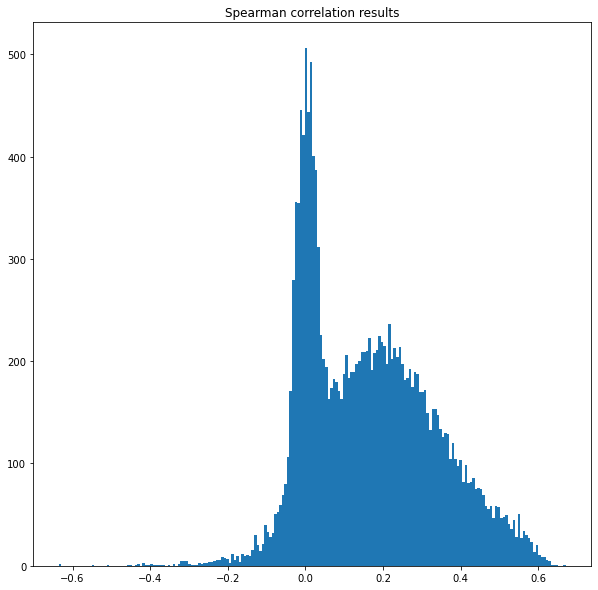

median=0.1453806121385317
best_gene=10736


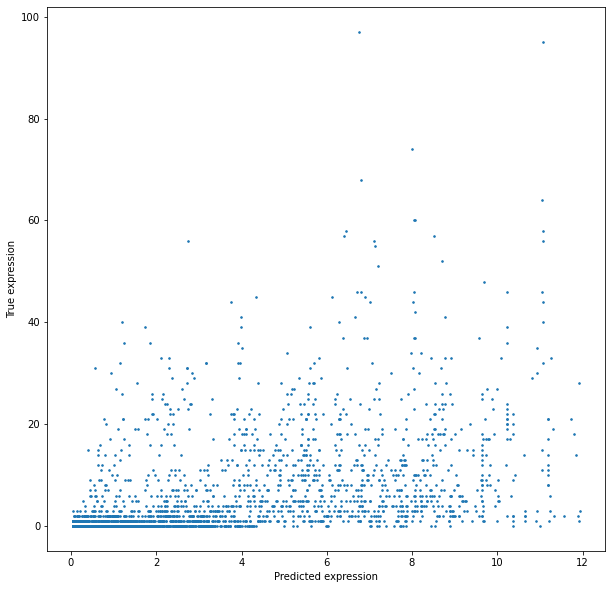

SpearmanrResult(correlation=0.6452202458483264, pvalue=1.4749043265e-313)


In [69]:
validation(preds, valid_dataset.counts)